num examples: 200


,estimator,method,value
5,pred_logprob,spearman,0.309383
2,echo_logprob,spearman,0.169330
3,pred_logprob,pearson,0.280189
0,echo_logprob,pearson,0.126379
4,pred_logprob,kendall,0.218687
1,echo_logprob,kendall,0.114198


en_to_fi
rougeL_score


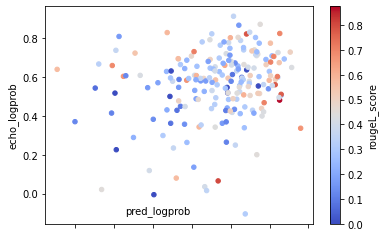

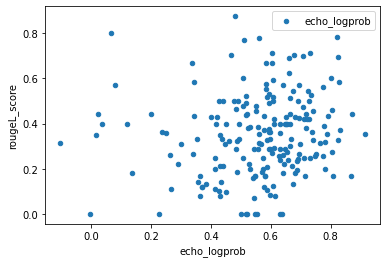

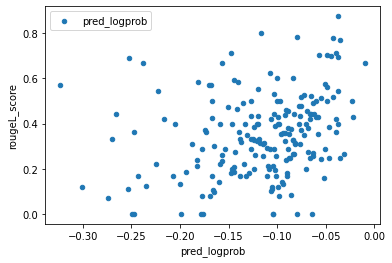

In [1]:
from pathlib import Path
import jsonlines
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

#TODO: Guy's idea - drop first tokens of echo because they may have very high variance


# metrics_path = Path("metrics") / "wmt19_de_to_en__text-curie-001__200_examples__metrics.json"
# metrics_path = Path("metrics") / "wmt19_en_to_de__text-curie-001__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_de_to_en__text-davinci-002__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_en_to_de__text-davinci-002__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_de_to_en__text-curie-001__200_examples__metrics.jsonl"
# metrics_path = Path("metrics") / "wmt19_ru_to_en__text-davinci-002__200_examples__metrics.jsonl"
# metrics_path = Path("openai_dump/wmt19_ru_to_en__text-davinci-002__200_examples/metrics.jsonl")
# metrics_path = Path("openai_dump/wmt19_fi_to_en__text-davinci-002__200_examples/metrics.jsonl")
# metrics_path = Path("openai_dump/wmt19_tr_to_en__text-davinci-002__200_examples/metrics.jsonl")
# metrics_path = Path("openai_dump/wmt19_de_to_en__text-davinci-002__200_examples/metrics.jsonl")
# score_name = "rouge2_score"
# score_name = "rougeL_score"
# score_name = "bleu_score"
metrics_path = Path("openai_dump/wmt19_en_to_fi__text-davinci-002__200_examples/metrics.jsonl")
# score_name = "bertscore_f1"
score_name = "rougeL_score"
binary = False
denormalize_logprob = None
assert denormalize_logprob in ("length", "sqrt_length", None)

languages = '_'.join(metrics_path.parent.name.split('__')[0].split('_')[1:])

if metrics_path.suffix == ".jsonl":
    with jsonlines.open(metrics_path, 'r') as reader:
        metrics = list(reader.iter())
elif metrics_path.suffix == ".json":
    metrics = json.loads(metrics_path.read_text())
else:
    raise ValueError()

metrics = pd.DataFrame(metrics)
print(f"num examples: {len(metrics)}")
metrics = metrics.rename(columns={col: col.replace("perplexity", "logprob") for col in metrics.columns if "perplexity" in col})

backtranslation_metrics_path = metrics_path.parent / "backtranslation" / "dump" / "metrics.jsonl"
if backtranslation_metrics_path.exists():
    with jsonlines.open(backtranslation_metrics_path, 'r') as reader:
        bt_metrics = list(reader.iter())
    bt_metrics = pd.DataFrame(bt_metrics)
    bt_metrics = bt_metrics.sort_values("i_example").reset_index(drop=True)
    bt_metrics = bt_metrics.rename(columns={col: f"BT_{col}" for col in bt_metrics.columns})
    metrics = pd.concat([metrics, bt_metrics], axis=1)

    # CAREFUL!
    metrics["echo_logprob"] = metrics["BT_bertscore_f1"]


# metrics["pred_prob"] = np.exp(metrics["pred_logprob"])
# metrics["echo_prob"] = np.exp(metrics["echo_logprob"])
# metrics = metrics.loc[metrics["bleu_score"] > 0]
# metrics = metrics.loc[metrics["bleu_score"] == 0]

sentences_path = metrics_path.parent / "sentences.jsonl"
with jsonlines.open(sentences_path, 'r') as reader:
    sentences = list(reader)
sentences = pd.DataFrame(sentences)

sentences["input_length"] = sentences["input_text"].map(len)
sentences["pred_length"] = sentences["pred_text"].map(len)
if denormalize_logprob is not None:
    op = np.sqrt if denormalize_logprob == "sqrt_length" else lambda x: x
    metrics["echo_logprob"] *= op(sentences["input_length"])
    metrics["pred_logprob"] *= op(sentences["pred_length"])

if binary:
    metrics[score_name] = (metrics[score_name] != 0).astype(float)

estimators = ["pred_logprob", "echo_logprob", "pred_prob", "echo_prob"]
estimators = set(estimators).intersection(metrics.columns)
correlation_method = ["pearson","kendall", "spearman"]
correlations = []
for col in estimators:
    for method in correlation_method:
        corr = metrics[col].corr(metrics[score_name], method=method)
        correlations.append({"estimator": col, "method": method, "value": corr})
correlations = pd.DataFrame(correlations)
correlations = correlations.sort_values(["method", "value"], ascending=False)
display(correlations)

ax = metrics.plot(x="pred_logprob", y="echo_logprob", c=score_name, kind='scatter', cmap="coolwarm")
plt.text(0.3,0.05,"pred_logprob",transform=ax.transAxes)

for col in estimators:
    metrics.plot(x=col, y=score_name, label=col, kind='scatter')

print(languages)
print(score_name)

In [2]:
from torch import nn
from torch import tensor
from torch.optim import AdamW, SGD
from tqdm import tqdm
import torch
from sklearn.svm import SVR, SVC


pred = metrics["pred_logprob"].values
echo = metrics["echo_logprob"].values
targets = metrics[score_name].values
features = np.vstack([pred, echo]).T

model_type = "svr_poly"
if binary:
    model = SVC(kernel="linear", verbose=2)
    model.fit(features, targets)
    if features.shape[1] > 1:
        print(f"\n\nLinearSVC coeffs: pred={model.coef_[0,0]:.3f}, echo={model.coef_[0,1]:.3f}, intercept={model.intercept_[0]:.3f}\n\n")
elif "logistic" in model_type:
    if model_type == "explicit_ploynomial_logistic_regression":
        features = np.vstack([pred**2, pred*echo, echo**2, pred, echo]).T
    features = tensor(features, dtype=torch.float32)
    targets = tensor(targets, dtype=torch.float32)

    model = nn.Linear(in_features=features.shape[1], out_features=1)
    optimizer = AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    epochs = 2000
    prog_bar = tqdm(range(epochs))
    for _ in prog_bar:
        res = model(features).flatten()
        loss = loss_fn(res, targets)
        prog_bar.set_description(f"{loss.item():3f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
elif model_type == "svr_poly":
    model = SVR(kernel="poly", degree=2, verbose=2)
    model.fit(features, targets)
elif model_type == "svr_rbf":
    model = SVR(kernel="rbf", verbose=2)
    model.fit(features, targets)
elif model_type == "svr_linear":
    model = SVR(kernel="linear", verbose=2)
    model.fit(features, targets)
    print(f"\n\nLinearSVR coeffs: pred={model.coef_[0,0]:.3f}, echo={model.coef_[0,1]:.3f}, intercept={model.intercept_[0]:.3f}\n\n")
else:
    raise ValueError(f"Unsupported model type '{model_type}'")



[LibSVM]*..
*
optimization finished, #iter = 1042
obj = -12.229371, rho = -0.312107
nSV = 120, nBSV = 116


rougeL_score
corr 0.2855366027078205


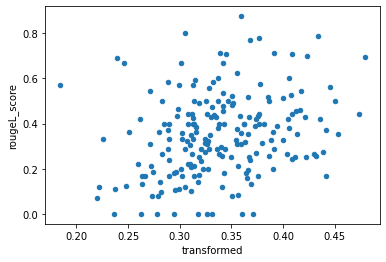

In [3]:
# weights = torch.concat([model.weight.flatten(), model.bias.flatten()]).data.numpy()
if isinstance(model, nn.Module):
    transformed = model(features).flatten().sigmoid().data.numpy()
else:
    transformed = model.predict(features)
pd.DataFrame({"transformed": transformed, score_name: metrics[score_name]}).plot(x="transformed", y=score_name, kind="scatter")
print(score_name)
print("corr", pd.Series(transformed).corr(metrics[score_name], method="spearman"))
if binary:
    print("accuracy", (transformed == metrics[score_name]).mean())

In [4]:
if binary:
    print("both accuracy:", (SVC(kernel="linear", verbose=0).fit(features, targets).predict(features) == targets).mean())
    print("echo accuracy:", (SVC(kernel="linear", verbose=0).fit(echo[:,None], targets).predict(echo[:,None]) == targets).mean())
    print("pred accuracy:", (SVC(kernel="linear", verbose=0).fit(pred[:,None], targets).predict(pred[:,None]) == targets).mean())

<AxesSubplot:xlabel='pred_logprob', ylabel='echo_logprob'>

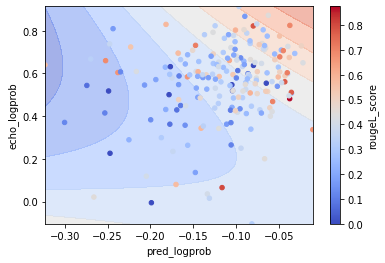

In [5]:
%matplotlib inline
mesh_density = 100
x_mesh = np.linspace(metrics["pred_logprob"].min(), metrics["pred_logprob"].max(), mesh_density)
y_mesh = np.linspace(metrics["echo_logprob"].min(), metrics["echo_logprob"].max(), mesh_density)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
shape = x_mesh.shape
x_mesh = x_mesh.flatten()
y_mesh = y_mesh.flatten()

features_mesh = np.vstack([x_mesh,y_mesh]).T
if isinstance(model, nn.Module):
    if model_type == "explicit_ploynomial_logistic_regression":
        features_mesh = np.vstack([x_mesh**2,x_mesh*y_mesh,y_mesh**2,x_mesh,y_mesh]).T
    features_mesh = tensor(features_mesh, dtype=torch.float32)
    model_res = model(features_mesh).sigmoid().flatten().data.numpy()
else:
    model_res = model.predict(features_mesh)

fig, ax = plt.subplots()
ax.contourf(x_mesh.reshape(shape), y_mesh.reshape(shape), model_res.reshape(shape), cmap="coolwarm", alpha=0.5)
metrics.plot(x="pred_logprob", y="echo_logprob", c=score_name, kind='scatter', cmap="coolwarm", ax=ax)


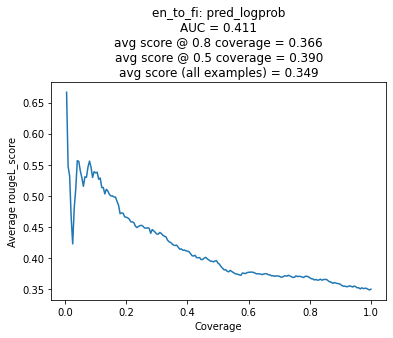

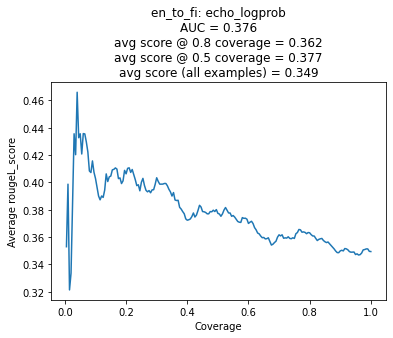

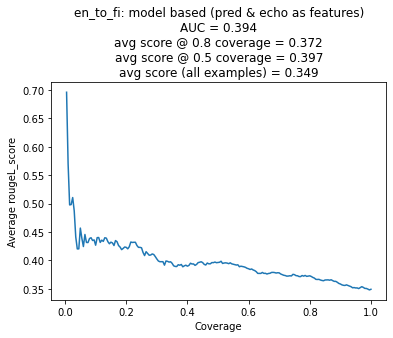

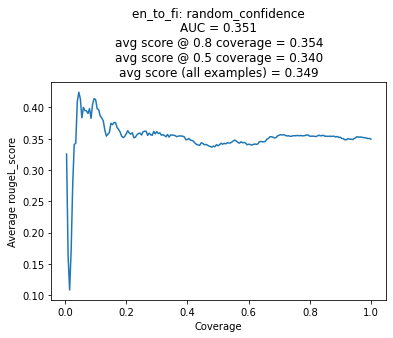

In [6]:
metrics["random_confidence"] = np.random.rand(metrics.shape[0])
for conf_measure_name, confidence_measure in (
    ("pred_logprob", metrics["pred_logprob"].values),
    ("echo_logprob", metrics["echo_logprob"].values),
    ("model based (pred & echo as features)", transformed),
    ("random_confidence", metrics["random_confidence"].values)
    ):
    I = np.argsort(confidence_measure)[::-1]
    conf = confidence_measure[I]
    score = metrics[score_name].values[I]
    avg_score = np.cumsum(score) / np.arange(1, len(score) + 1)
    avg_score_at_08_coverage = avg_score[int(len(avg_score) * 0.8)]
    coverage = np.arange(1, len(score) + 1) / len(score)
    auc = np.trapz(avg_score, coverage)
    plt.figure()
    plt.title(f"{languages}: {conf_measure_name}\n"
              f"AUC = {auc:.3f}\n"
              f"avg score @ 0.8 coverage = {avg_score_at_08_coverage:.3f}\n"
              f"avg score @ 0.5 coverage = {avg_score[int(len(avg_score) * 0.5)]:.3f}\n"
              f"avg score (all examples) = {avg_score[-1]:.3f}")
    plt.xlabel("Coverage")
    plt.ylabel(f"Average {score_name}")
    plt.plot(coverage, avg_score)
    plt.show()


In [7]:
sorted_df = pd.concat([sentences, metrics], axis=1)
conf_measure_name = "echo_logprob"
# sorted_df = sentences.copy(deep=True)
# sorted_df["echo_logprob"] = sorted_df["echo_logprob"] * np.sqrt(sorted_df["input_text"].map(len))
sorted_df = sorted_df.sort_values(conf_measure_name, ascending=False)
print('\n')
for _, row in sorted_df.iterrows():
    print(f"BertScoreF1: {row['bertscore_f1']:.3f}    {conf_measure_name}: {row[conf_measure_name]:.3f}\n"
        f"target:\t{row['target_text']}\n{'-'*10}\npred:\t{row['pred_text']}\n\n")

KeyError: 'bertscore_f1'